<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/project/AIprojectGioAlf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBLIC TRANSPORT PROJECT
The project will be divided into two parts, in both cases I will create models that estimate the arrival delay at different stages of the trip:\
* **Part A** will have limited available data, it will be missing all the real time data such as `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay` and `travel_time_for_previous_section`

* **Part B** will have all the available data that will lead to a more accurate prediction.

### METHOD
I will use different methods to create prediction models and obtain the best predictions possible, I will then likely use the best model I can get to predict the delays and then check the accuracy of them.\
I can also maybe do some feature engineering and use day of the week and stuff like that.

## DATA HANDLING
Here I will import the dataset and clean it to make it easier to use for my purposes

In [1]:
%pip install pandasql
import pandas as pd
import numpy as np
import pandasql
from pandasql import sqldf

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, skiprows=1, header=0)

display(df.head())

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=0ac83564eaf18b2bb240b82e1bbaf9c5dbf1ce98c96e3aa5e823c47c41604623
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

I noticed that with the current data I can't associate each row with a specific trip but only with a date and vehicle, so I will add that feature in the most trivial way by just adding a column with a sequential number for each trip.

In [3]:
def trip_counter(group):
    # create a counter that increases every 27 rows
    n_rows = len(group)
    group['trip_number'] = np.arange(n_rows) // 27 + 1
    return group

df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)

/tmp/ipython-input-3494565459.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)


In [5]:
 # checking that there is only 27 rows to each date-trip pair so that I didn't make mistakes in the cleaning process
(df.groupby(['Calendar_date', 'trip_number']).size().reset_index(name='count'))['count'].unique()

array([27])

###**Descriptive analysis**
I will explore the dataset to gain insights on possible trends or outliers

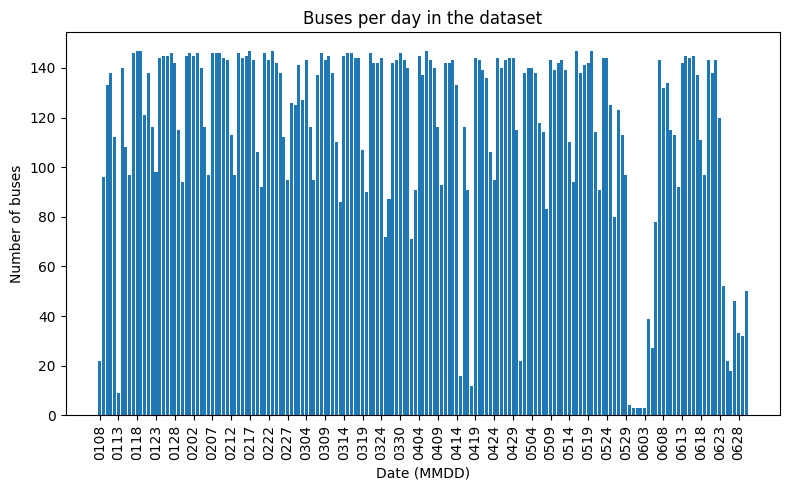

In [7]:
import matplotlib.pyplot as plt

counts = df['Calendar_date'].astype(str).str[-4:].value_counts().sort_index() / 27

plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.xlabel('Date (MMDD)')
plt.ylabel('Number of buses')
plt.title('Buses per day in the dataset')

# Show every 5th tick label
plt.xticks(rotation=90, ticks=range(0, len(counts.index), 5),
           labels=counts.index[::5])

plt.tight_layout()
plt.show()


Trying to understand why there are peaks and valleys in the average arrival delays

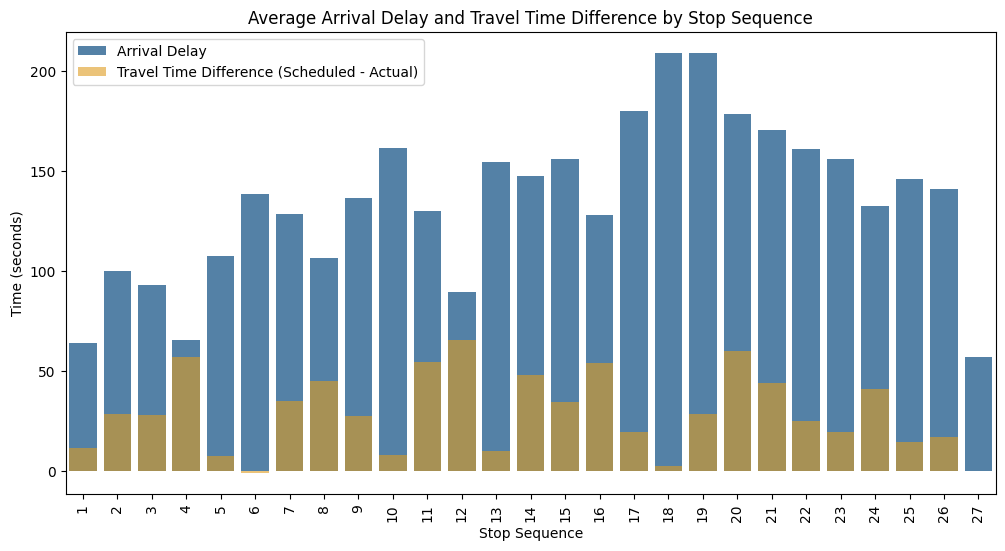

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Calculate averages by stop
average_by_stop = df.groupby('stop_sequence')[['arrival_delay', 'scheduled_travel_time', 'travel_time_for_previous_section']].mean().reset_index()

# 2. Compute difference (scheduled - actual) and shift travel_time_for_previous_section to align with the stop
average_by_stop['travel_time_diff'] = average_by_stop['scheduled_travel_time'] - average_by_stop['travel_time_for_previous_section'].shift(-1)

# arrival time from scheduled departure
average_by_stop['arrival_delay_from_scheduled'] = average_by_stop['arrival_delay'] + average_by_stop['travel_time_diff']

# 3. Plot using overlapping bar style
plt.figure(figsize=(12, 6))

# Arrival delay (all stops)
sns.barplot(
    data=average_by_stop,
    x='stop_sequence',
    y='arrival_delay',
    color='steelblue',
    label='Arrival Delay'
)

# Travel time difference (scheduled - actual), last stop will be ignored automatically
sns.barplot(
    data=average_by_stop,
    x='stop_sequence',
    y='travel_time_diff',
    color='orange',
    alpha=0.6,
    label='Travel Time Difference (Scheduled - Actual)'
)


plt.title('Average Arrival Delay and Travel Time Difference by Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=90)
plt.legend()
plt.show()


Average arrival delay by time of day and stop sequence

Average Arrival Delay by Stop Sequence and Time of Day:


,stop_sequence,time_of_day,arrival_delay
0,1,AP,54.393781
1,1,MP,34.141484
2,1,OP,74.997470
3,2,AP,93.186565
4,2,MP,61.530490
...,...,...,...
76,26,MP,106.254130
77,26,OP,172.395983
78,27,AP,-23.506765
79,27,MP,19.576449


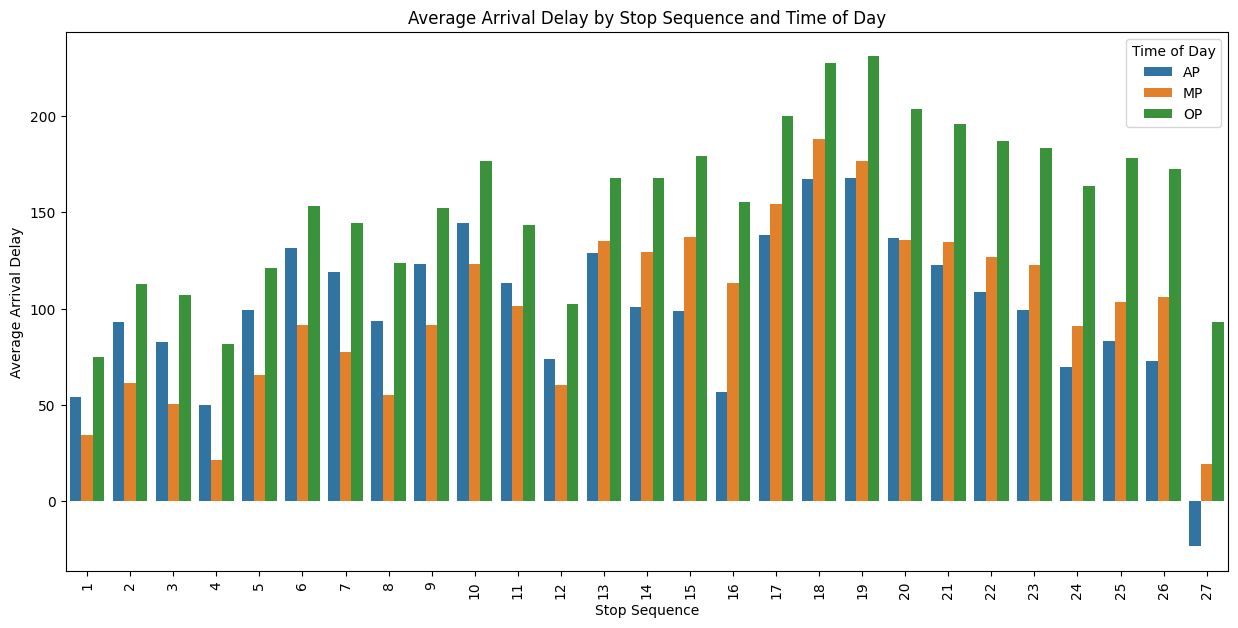

In [11]:
# Calculate the average arrival delay for each stop sequence and time of day
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Display the average arrival delay by stop sequence and time of day
print("Average Arrival Delay by Stop Sequence and Time of Day:")
display(average_delay_by_stop_and_time)

# Visualize the average arrival delay by stop sequence and time of day using a grouped bar plot
plt.figure(figsize=(15, 7))
sns.barplot(data=average_delay_by_stop_and_time, x='stop_sequence', y='arrival_delay', hue='time_of_day')
plt.title('Average Arrival Delay by Stop Sequence and Time of Day')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()

### **OUTLIER DETECTION**

Distribution of arrival delays to spot outliers, the logarithmic scale is to highlight extreme values that could be overshadowed by more frequent central values

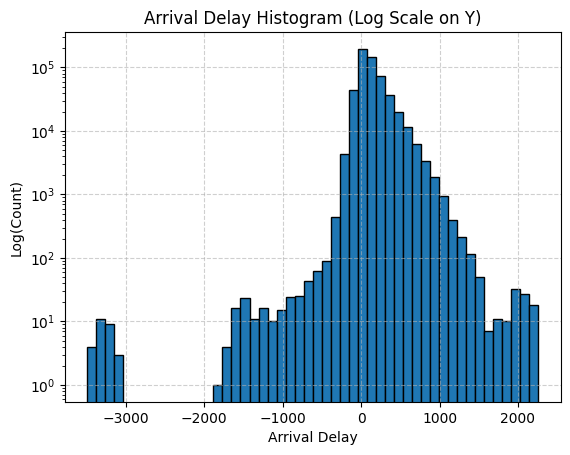

In [13]:
import matplotlib.pyplot as plt

plt.hist(df['arrival_delay'], bins=50, edgecolor='black')
plt.yscale('log')
plt.title("Arrival Delay Histogram (Log Scale on Y)")
plt.xlabel("Arrival Delay")
plt.ylabel("Log(Count)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


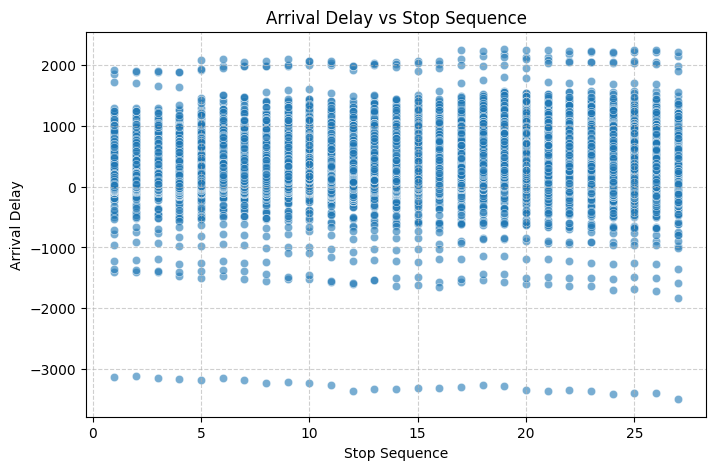

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='stop_sequence', y='arrival_delay', alpha=0.6)

plt.title("Arrival Delay vs Stop Sequence")
plt.xlabel("Stop Sequence")
plt.ylabel("Arrival Delay")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Filtering the rows with arrival delay > 1400s and grouping them by date and trip number

In [15]:
late=df[df['arrival_delay']>1400]
late.groupby(['Calendar_date', 'trip_number']).size().reset_index(name='count')

,Calendar_date,trip_number,count
0,20220120,8,9
1,20220120,9,9
2,20220120,10,8
3,20220320,52,7
4,20220405,19,3
5,20220525,2,27
6,20220608,45,5
7,20220609,134,27
8,20220610,48,8
9,20220610,59,17


Filtering the rows with arrival delay < 420s (7min) and grouping them by date and trip number

In [16]:
early=df[df['arrival_delay']<-420]
early.groupby(['Calendar_date', 'trip_number']).size().reset_index(name='count')

,Calendar_date,trip_number,count
0,20220413,89,1
1,20220503,100,1
2,20220517,103,1
3,20220525,15,27
4,20220525,35,27
5,20220525,48,27
6,20220525,60,27
7,20220525,71,1
8,20220525,81,22
9,20220525,87,23


**I manually selected some trips** (entire trips stops 1-27) that had **strange behaviors** in terms of delay that is not my intention to replicate in the model (as they are believed to be exceptions to regular bus operations)\
**20220525** was early in several trips,\
**20220610** was late in several trips,\
the rest are singular trips that were either very early or very late

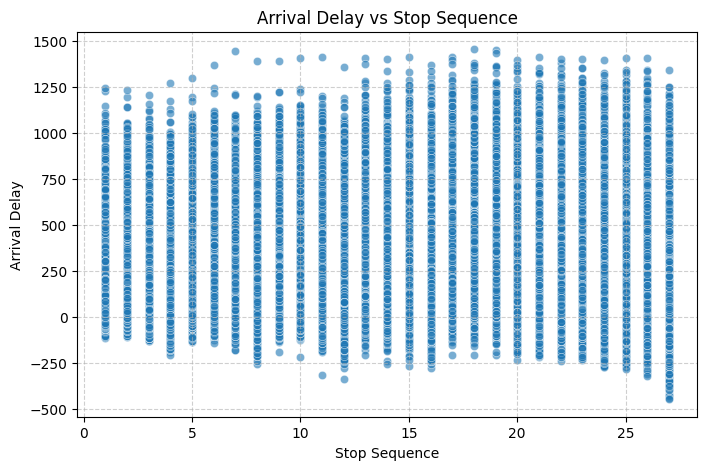

In [17]:
# creating a new df that removes outliers
df_try=df[
    (df['Calendar_date']!=20220525) & # early
    (df['Calendar_date']!=20220610) & # late
    ~((df['Calendar_date']==20220628) & (df['trip_number']==22)) & # early
    ~((df['Calendar_date']==20220630) & (df['trip_number']==11)) & # early
    ~((df['Calendar_date']==20220609) & (df['trip_number']==134)) & # late
    ~((df['Calendar_date']==20220120) & (df['trip_number'].isin([8,9,10]))) # late
    ]
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_try, x='stop_sequence', y='arrival_delay', alpha=0.6)

plt.title("Arrival Delay vs Stop Sequence")
plt.xlabel("Stop Sequence")
plt.ylabel("Arrival Delay")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## PART A - Existing ITS
I will get rid of some of the features that are only available in real time, i.e: `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay`, `travel_time_for_previous_section`.

In [18]:
dfA=df_try.drop(['upstream_stop_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'recurrent_delay', 'travel_time_for_previous_section'], axis=1)

In [20]:
dfA_clean=dfA.copy()

I will add the arrival delay at stop 20 of each run to every row of that run to be used as the target.\

In [21]:
# Filter for rows where stop_sequence is 20
delay_at_stop_20 = dfA_clean[dfA_clean['stop_sequence'] == 20][['Calendar_date', 'trip_number', 'arrival_delay']]

# Rename the 'arrival_delay' column to indicate it's the delay at stop 20
delay_at_stop_20 = delay_at_stop_20.rename(columns={'arrival_delay': 'arrival_delay_stop_20'})

# Merge this information back into dfA_clean
dfA_clean = pd.merge(dfA_clean, delay_at_stop_20, on=['Calendar_date', 'trip_number'], how='left')

# Display the updated DataFrame
dfA_clean



,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,1,0,1,0,0,1,1,419
1,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,1,0,1,0,0,1,1,419
2,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,1,0,1,0,0,1,1,419
3,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,1,0,1,0,0,1,1,419
4,20220108,4,41344,5,242,21,86,100,102.000000,Light Snow,...,0,0,1,0,1,0,0,1,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538456,20220630,4,41362,23,344,13,44,12,32.666667,Normal,...,0,0,1,1,0,0,0,1,50,274
538457,20220630,4,41362,24,330,15,92,12,77.000000,Normal,...,0,0,1,1,0,0,0,1,50,274
538458,20220630,4,41362,25,339,17,43,12,38.000000,Normal,...,0,0,1,1,0,0,0,1,50,274
538459,20220630,4,41362,26,331,0,58,12,50.666667,Normal,...,0,0,1,1,0,0,0,1,50,274


In [22]:
dfA_clean.columns

Index(['Calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay',
       'dwell_time', 'scheduled_travel_time', 'origin_delay',
       'traffic_condition', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
       'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
       'factor(temperature)Cold', 'factor(temperature)Extra_cold',
       'factor(temperature)Normal', 'factor(day_of_week)weekday',
       'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
       'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak',
       'trip_number', 'arrival_delay_stop_20'],
      dtype='object')

Now I can remove the unwanted columns of the df and `arrival_delay` as it was supposed to be the target feature so in this case it would be leaking information.

In [23]:
# Dropping the redundant and the 'arrival delay'
dfA_clean=dfA_clean.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number', 'arrival_delay'], axis=1)


### **MODEL 1 General Linear Regression**

In this model I will try to do a linear regression on the whole dataset to see what comes out.\
I assume this will perform poorly as it is a huge training of the whole dataset and I will test it from specific stop numbers. I'm not even sure it will run, and also I think it might leak data since I use delays from stops that are further away.

In [90]:
dfA_model1=dfA_clean.copy()

`origin_delay` is highly correlated with `arrival_delay_stop_20` and it will probably play a big role in predicting the value I need.

In [91]:
corr_matrix = dfA_model1.corr()
corr_matrix['arrival_delay_stop_20'].sort_values(ascending=False)

,arrival_delay_stop_20
arrival_delay_stop_20,1.000000e+00
origin_delay,6.516454e-01
factor(day_of_week)weekend,2.071650e-01
factor(time_of_day)Off-peak,1.677602e-01
Calendar_date,1.385888e-01
dwell_time,5.376166e-02
factor(temperature)Normal,3.547845e-02
factor(weather)Normal,2.276069e-02
factor(weather)Rain,1.139223e-02
stop_sequence,-2.914861e-15


In [92]:
# Separating the df to not leak any data
dfA_model1_train=dfA_model1[dfA_model1['Calendar_date']<20220600]
dfA_model1_test=dfA_model1[dfA_model1['Calendar_date']>=20220600].copy()

**I will now define the train data which is going to be 80% of the df then I will test it on different hypothesis**

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = dfA_model1.drop(['arrival_delay_stop_20'], axis=1)
y = dfA_model1['arrival_delay_stop_20']

X_train=dfA_model1_train.drop(['arrival_delay_stop_20'], axis=1)
X_test=dfA_model1_test.drop(['arrival_delay_stop_20'], axis=1)
y_train=dfA_model1_train['arrival_delay_stop_20']
y_test=dfA_model1_test['arrival_delay_stop_20']

# I remove non-predictive columns
X_train_clean=X_train.drop(['Calendar_date', 'stop_sequence'], axis=1)
X_test_clean=X_test.drop(['Calendar_date', 'stop_sequence'], axis=1)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

In [94]:
# Create a Linear Regression model
model1 = LinearRegression()

# Fit the model to the training data
model1.fit(X_train_scaled, y_train)

# Predict the test data with the fitted model
y_pred_A1_1 = model1.predict(X_test_scaled)

Showing the coefficients of the LR to understand how it works and what features are most important

In [95]:
# Get the coefficients and the feature names
coefficients = model1.coef_
feature_names = X_train_clean.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
origin_delay,119.097094
dwell_time,13.552361
factor(time_of_day)Afternoon_peak,-11.645659
factor(day_of_week)weekend,8.751827
factor(day_of_week)weekday,-8.751827
factor(time_of_day)Off-peak,8.747810
scheduled_travel_time,-6.078661
traffic_condition,4.680568
factor(weather)Light_Rain,-2.796343
factor(temperature)Cold,2.095794


In [96]:
mae = mean_absolute_error(y_test, y_pred_A1_1)
mse = mean_squared_error(y_test, y_pred_A1_1)
r2 = r2_score(y_test, y_pred_A1_1)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 122.39517124561026
Mean Squared Error: 25566.54010783776
R-squared: 0.5181371742519052


**Testing on all stops**\
Now I will try to use some of the test data, specifically the data collected in the rows related to all specific stops, and get error metrics from all of them.


In [97]:
evaluation_results = []

for stop_seq in range(1, 27):  # Loop from stop_sequence 1 to 19 (exclusive of 20)
    # Filter the test data for the current stop sequence
    X_test_seq = X_test[X_test['stop_sequence'] == stop_seq].drop(['Calendar_date', 'stop_sequence'], axis=1)
    y_test_seq = y_test.loc[X_test_seq.index]

    # Check if there are samples for the current stop sequence
    if not X_test_seq.empty:
        # Normalize the features using the scaler fitted on the training data
        X_test_scaled_seq = scaler.transform(X_test_seq)

        # Predict the test data with the fitted model
        y_pred_seq = model1.predict(X_test_scaled_seq)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test_seq, y_pred_seq)
        mse = mean_squared_error(y_test_seq, y_pred_seq)
        r2 = r2_score(y_test_seq, y_pred_seq)

        # Store the results in a dictionary
        results = {
            'stop_sequence': stop_seq,
            'MAE': mae,
            'MSE': mse,
            'R-squared': r2
        }
        evaluation_results.append(results)
    else:
        print(f"No test samples for stop sequence {stop_seq}")

# Convert the list of dictionaries to a DataFrame for better viewing
evaluation_df_1 = pd.DataFrame(evaluation_results)

# Display the results
print("Evaluation Metrics by Stop Sequence:")
display(evaluation_df_1)

Evaluation Metrics by Stop Sequence:


,stop_sequence,MAE,MSE,R-squared
0,1,123.277234,26396.150450,0.502501
1,2,122.002937,24691.220670,0.534635
2,3,122.515571,25740.089786,0.514866
3,4,121.913306,25500.982745,0.519373
4,5,123.039412,25250.956783,0.524085
5,6,121.942323,25173.274165,0.525549
6,7,122.076945,25573.876865,0.517999
7,8,122.082844,25637.993626,0.516790
8,9,122.114176,24951.917804,0.529721
9,10,121.781681,25295.534475,0.523245


### **MODEL 2 Linear Regression on single stops**
In this other case I will try to make multiple models that will only be trained from a specific stop, I will try with linear regression again and if it looks promising I will improve on it

I will now divide the df into smaller df that only contain rows from a specific stop

In [35]:
dfA_model2=dfA_clean.copy()

In [36]:
from sklearn.model_selection import TimeSeriesSplit

df2 = {}
models2 = {}
test_train2={}
results2 = {}
predictions2 = {}

for i in range(1, 21):
    # Filter data for this stop
    dfA_model2_i = dfA_model2[dfA_model2['stop_sequence'] == i].copy()
    df2[f'stop_{i}'] = dfA_model2_i

    # Split by date before dropping the column
    dfA_model2_train = dfA_model2_i[dfA_model2_i['Calendar_date'] < 20220600].copy()
    dfA_model2_test = dfA_model2_i[dfA_model2_i['Calendar_date'] >= 20220600].copy()

    # Drop non-predictive columns
    cols_to_drop = ['Calendar_date', 'stop_sequence']
    X_train = dfA_model2_train.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_train = dfA_model2_train['arrival_delay_stop_20']

    X_test = dfA_model2_test.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_test = dfA_model2_test['arrival_delay_stop_20']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    test_train2[f'stop_{i}'] = {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled, 'y_train': y_train, 'y_test': y_test}

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    predictions2[f'stop_{i}'] = y_pred
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    models2[f'model_stop_{i}'] = model
    results2[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Display performance summary
pd.DataFrame(results2).T



,R2,MAE,MSE
stop_1,0.514283,122.927035,25771.059350
stop_2,0.550753,118.960172,23836.015894
stop_3,0.525218,121.816787,25190.845076
stop_4,0.535233,120.792837,24659.483115
stop_5,0.522577,121.927667,25330.965538
stop_6,0.548523,119.111405,23954.363417
stop_7,0.537969,119.717076,24514.325369
stop_8,0.541470,119.807392,24328.571077
stop_9,0.515204,120.993126,25722.189249
stop_10,0.517111,120.864979,25620.985433


Plotting the predicted vs actual delays to grasp the reasons behind these poor predictions

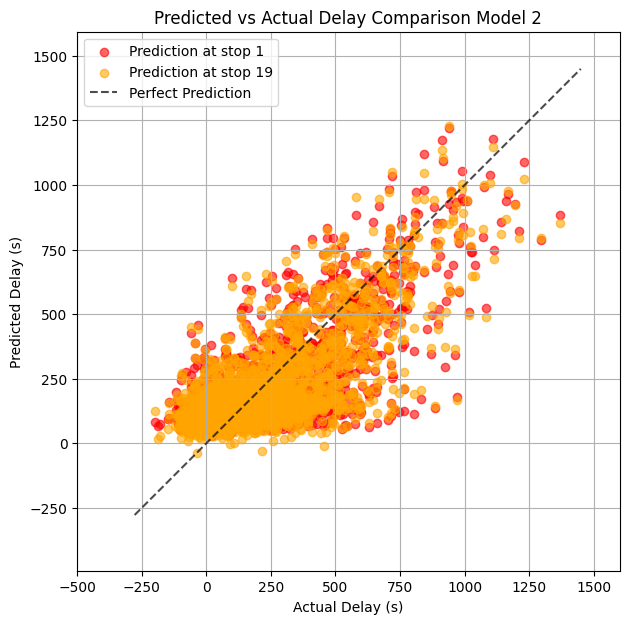

In [76]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,7))

# Scatter 0
plt.scatter(test_train2['stop_1']['y_test'], predictions2['stop_1'], alpha=0.6, label='Prediction at stop 1', color='red')

# # Scatter 1
# plt.scatter(test_train2['stop_7']['y_test'], predictions2['stop_7'], alpha=0.6, label='Prediction at stop 7', color='limegreen')

# # Scatter 2
# plt.scatter(test_train2['stop_13']['y_test'], predictions2['stop_14'], alpha=0.6, label='Prediction at stop 13', color='steelblue')

# Scatter 3
plt.scatter(test_train2['stop_19']['y_test'], predictions2['stop_19'], alpha=0.6, label='Prediction at stop 19', color='orange')


# Diagonal line (perfect prediction)
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]])
]
plt.plot(lims, lims, 'k--', alpha=0.7, label='Perfect Prediction')

# Labels, legend, limits
plt.xlabel('Actual Delay (s)')
plt.ylabel('Predicted Delay (s)')
plt.title('Predicted vs Actual Delay Comparison Model 2')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Limit axes
plt.xlim(-500, 1600)
plt.ylim(-500, 1600)

plt.show()


### **MODEL 3 XGBoost on single stops**
Now I'll try to do the same with XGBoost as the model to compare performance, the procedure is actually the same as before only model changes and hyperparameter tuning

In [40]:
# !pip install xgboost

In [41]:
dfA_model3=dfA_clean.copy()

In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df3 = {}
models3 = {}
results3 = {}

# Define the grid of hyperparameters

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


for i in range(1, 21):
    # Filter data for this stop
    dfA_model3_i = dfA_model3[dfA_model3['stop_sequence'] == i].copy()
    df3[f'stop_{i}'] = dfA_model3_i

    # Split by date
    dfA_model3_train = dfA_model3_i[dfA_model3_i['Calendar_date'] < 20220600].copy()
    dfA_model3_test = dfA_model3_i[dfA_model3_i['Calendar_date'] >= 20220600].copy()

    # Drop non-predictive columns
    cols_to_drop = ['Calendar_date', 'stop_sequence']
    X_train = dfA_model3_train.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_train = dfA_model3_train['arrival_delay_stop_20']

    X_test = dfA_model3_test.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_test = dfA_model3_test['arrival_delay_stop_20']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create XGBRegressor
    xgb = XGBRegressor(random_state=42)

    # Grid search
    random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,       # number of random combinations to try
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42
    )
    random_search.fit(X_train_scaled, y_train)

    # Best model
    best_model = random_search.best_estimator_
    models3[f'model_stop_{i}'] = best_model

    # Evaluate
    y_pred = best_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    results3[f'stop_{i}'] = {
        'R2': r2,
        'MAE': mae,
        'MSE': mse,
        'BestParams': random_search.best_params_
    }

# Display summary
pd.DataFrame(results3).T


,R2,MAE,MSE,BestParams
stop_1,0.522102,122.093246,25356.183594,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_2,0.554393,118.03067,23642.865234,"{'subsample': 0.8, 'n_estimators': 300, 'max_d..."
stop_3,0.529995,120.731842,24937.373047,"{'subsample': 0.8, 'n_estimators': 300, 'max_d..."
stop_4,0.542128,120.115456,24293.636719,"{'subsample': 0.8, 'n_estimators': 300, 'max_d..."
stop_5,0.546799,118.238716,24045.806641,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_6,0.55841,116.841797,23429.759766,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_7,0.547124,118.098434,24028.591797,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_8,0.555308,117.439804,23594.335938,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_9,0.532388,119.706436,24810.398438,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_10,0.523412,120.577507,25286.697266,"{'subsample': 0.7, 'n_estimators': 100, 'max_d..."


Comparison of the 3 models based on existing ITS

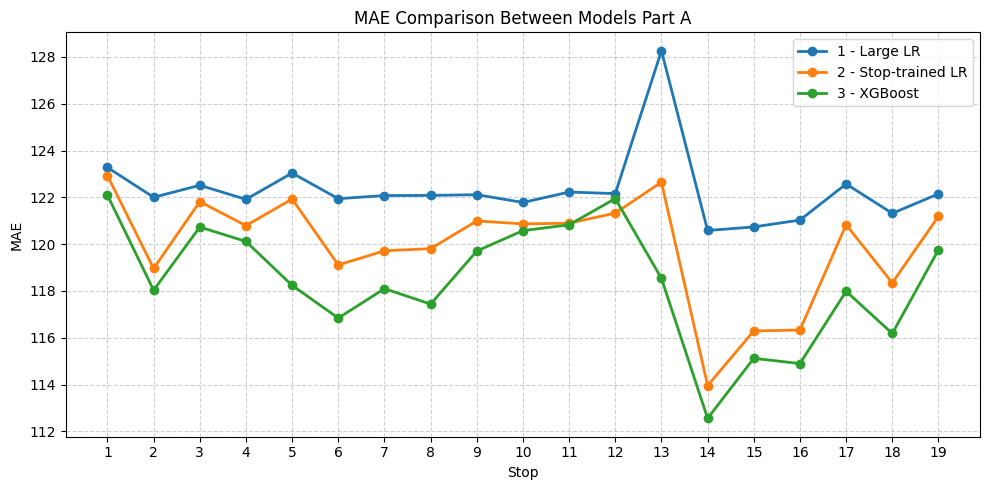

In [43]:
import matplotlib.pyplot as plt

# --- Extract MAE values ---
stops = list(range(1, 20))
mae1 = evaluation_df_1['MAE'].to_list()[:19]
mae3 = [v['MAE'] for v in results3.values()]
mae2 = [v['MAE'] for v in results2.values()]

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(stops, mae1, marker='o', label='1 - Large LR', linewidth=2)
plt.plot(stops, mae2[:19], marker='o', label='2 - Stop-trained LR', linewidth=2)
plt.plot(stops, mae3[:19], marker='o', label='3 - XGBoost', linewidth=2)

plt.xticks(stops)  # force integer ticks on x-axis
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between Models Part A')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## PART B - Advanced ITS
In this part I will have the entire dataset to create my models, including the previously discarded variables that are captured in real-time, i.e: `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay` and `travel_time_for_previous_section`.
I will then assign the correspondent arrival delay for stop 20 to each row related to the same trip.


In [44]:
dfB=df_try.copy()

In [45]:
# Filter for rows where stop_sequence is 20
delay_at_stop_20_B = dfB[dfB['stop_sequence'] == 20][['Calendar_date', 'trip_number', 'arrival_delay']]

# Rename the 'arrival_delay' column to indicate it's the delay at stop 20
delay_at_stop_20_B = delay_at_stop_20_B.rename(columns={'arrival_delay': 'arrival_delay_stop_20'})

# Merge this information back into dfA_clean
dfB = pd.merge(dfB, delay_at_stop_20_B, on=['Calendar_date', 'trip_number'], how='left')

# Display the updated DataFrame
dfB

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,1,0,1,0,0,1,1,419
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,1,0,1,0,0,1,1,419
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,1,0,1,0,0,1,1,419
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,1,0,1,0,0,1,1,419
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,1,0,1,0,0,1,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538456,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,1,1,0,0,0,1,50,274
538457,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,1,1,0,0,0,1,50,274
538458,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,1,1,0,0,0,1,50,274
538459,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,1,1,0,0,0,1,50,274


### **MODEL 5 General Linear Regression**

This model functions like model 1

In [104]:
# Dropping the redundant and the 'arrival delay'
dfB_model5=dfB.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number', 'arrival_delay'], axis=1)

# Separating the df to not leak any data
dfB_model5_train=dfB_model5[dfB_model5['Calendar_date']<20220600]
dfB_model5_test=dfB_model5[dfB_model5['Calendar_date']>=20220600].copy()

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train=dfB_model5_train.drop(['arrival_delay_stop_20'], axis=1)
X_test=dfB_model5_test.drop(['arrival_delay_stop_20'], axis=1)
y_train=dfB_model5_train['arrival_delay_stop_20']
y_test=dfB_model5_test['arrival_delay_stop_20']

# I remove non-predictive columns
X_train_clean=X_train.drop(['Calendar_date', 'stop_sequence'], axis=1)
X_test_clean=X_test.drop(['Calendar_date', 'stop_sequence'], axis=1)

# Normalize the features and remove non predictive columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

In [106]:
# Create a Linear Regression model
model5 = LinearRegression()

# Fit the model to the training data
model5.fit(X_train_scaled, y_train)

# Predict the test data with the fitted model
y_pred_B1_1 = model5.predict(X_test_scaled)

In [107]:
mae = mean_absolute_error(y_test, y_pred_B1_1)
mse = mean_squared_error(y_test, y_pred_B1_1)
r2 = r2_score(y_test, y_pred_B1_1)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 73.74396926780584
Mean Squared Error: 10754.13148609815
R-squared: 0.7973125747754505


In [108]:
evaluation_results = []

for stop_seq in range(1, 27):  # Loop from stop_sequence 1 to 19 (exclusive of 20)
    # Filter the test data for the current stop sequence
    X_test_seq = X_test[X_test['stop_sequence'] == stop_seq].drop(['Calendar_date', 'stop_sequence'], axis=1)
    y_test_seq = y_test.loc[X_test_seq.index]

    # Check if there are samples for the current stop sequence
    if not X_test_seq.empty:
        # Normalize the features using the scaler fitted on the training data
        X_test_scaled_seq = scaler.transform(X_test_seq)

        # Predict the test data with the fitted model
        y_pred_seq = model5.predict(X_test_scaled_seq)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test_seq, y_pred_seq)
        mse = mean_squared_error(y_test_seq, y_pred_seq)
        r2 = r2_score(y_test_seq, y_pred_seq)

        # Store the results in a dictionary
        results = {
            'stop_sequence': stop_seq,
            'MAE': mae,
            'MSE': mse,
            'R-squared': r2
        }
        evaluation_results.append(results)
    else:
        print(f"No test samples for stop sequence {stop_seq}")

# Convert the list of dictionaries to a DataFrame for better viewing
evaluation_df_5 = pd.DataFrame(evaluation_results)

# Display the results
print("Evaluation Metrics by Stop Sequence:")
display(evaluation_df_5)

Evaluation Metrics by Stop Sequence:


,stop_sequence,MAE,MSE,R-squared
0,1,126.225254,28325.737193,0.466133
1,2,118.958110,24346.020725,0.541141
2,3,120.998644,25052.989833,0.527816
3,4,114.542876,22173.107007,0.582095
4,5,106.686980,19136.490396,0.639327
5,6,103.036322,17904.839028,0.662540
6,7,99.759525,16451.609270,0.689930
7,8,97.672399,15804.268731,0.702131
8,9,93.220949,14475.801434,0.727169
9,10,90.700297,13610.602913,0.743476


In [109]:
# Get the coefficients and the feature names
coefficients = model5.coef_
feature_names = X_train_clean.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
upstream_stop_delay,159.293358
dwell_time,20.835414
recurrent_delay,16.052524
origin_delay,11.474518
scheduled_travel_time,-10.147221
previous_bus_delay,-7.688481
factor(time_of_day)Off-peak,5.184053
factor(time_of_day)Afternoon_peak,-4.447705
traffic_condition,4.214031
travel_time_for_previous_section,3.188004


### **MODEL 6 Linear Regression on single stops**
With this model I aim to try the same method as the one tested in model 2 with the complete features set

In [51]:
# Dropping the redundant and the 'arrival delay'
dfB_model6=dfB.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number', 'arrival_delay'], axis=1)

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df6 = {}
models6 = {}
test_train6 = {}
results6 = {}
predictions6={}

for i in range(1, 21):
    # Filter data for this stop
    dfB_model6_i = dfB_model6[dfB_model6['stop_sequence'] == i].copy()
    df6[f'stop_{i}'] = dfB_model6_i

    # Split by date before dropping the column
    dfB_model6_train = dfB_model6_i[dfB_model6_i['Calendar_date'] < 20220600].copy()
    dfB_model6_test = dfB_model6_i[dfB_model6_i['Calendar_date'] >= 20220600].copy()

    # Drop non-predictive columns
    cols_to_drop = ['Calendar_date', 'stop_sequence']
    X_train = dfB_model6_train.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_train = dfB_model6_train['arrival_delay_stop_20']

    X_test = dfB_model6_test.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_test = dfB_model6_test['arrival_delay_stop_20']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    test_train6[f'stop_{i}'] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    predictions6[f'stop_{i}'] = y_pred
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    models6[f'model_stop_{i}'] = model
    results6[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Display performance summary
pd.DataFrame(results6).T


,R2,MAE,MSE
stop_1,0.513320,122.879396,25822.111468
stop_2,0.590903,114.352373,21705.769551
stop_3,0.600019,113.952345,21222.079834
stop_4,0.619482,110.526511,20189.389940
stop_5,0.661668,104.398722,17951.130481
stop_6,0.692899,98.747060,16294.095579
stop_7,0.703408,97.490649,15736.497190
stop_8,0.721210,94.777702,14791.958047
stop_9,0.745328,89.646389,13512.313234
stop_10,0.747212,89.048082,13412.362635


Plotting actual v predicted arrival delays to compare it with model 2

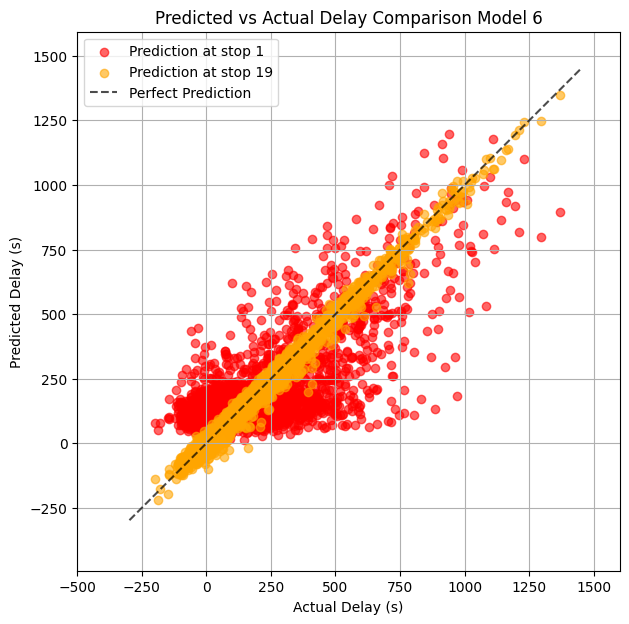

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,7))

# Scatter 0
plt.scatter(test_train6['stop_1']['y_test'], predictions6['stop_1'], alpha=0.6, label='Prediction at stop 1', color='red')

# # Scatter 1
# plt.scatter(test_train6['stop_7']['y_test'], predictions6['stop_7'], alpha=0.6, label='Prediction at stop 7', color='limegreen')

# # Scatter 2
# plt.scatter(test_train6['stop_13']['y_test'], predictions6['stop_14'], alpha=0.6, label='Prediction at stop 13', color='steelblue')

# Scatter 3
plt.scatter(test_train6['stop_19']['y_test'], predictions6['stop_19'], alpha=0.6, label='Prediction at stop 19', color='orange')


# Diagonal line (perfect prediction)
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]])
]
plt.plot(lims, lims, 'k--', alpha=0.7, label='Perfect Prediction')

# Labels, legend, limits
plt.xlabel('Actual Delay (s)')
plt.ylabel('Predicted Delay (s)')
plt.title('Predicted vs Actual Delay Comparison Model 6')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Limit axes
plt.xlim(-500, 1600)
plt.ylim(-500, 1600)

plt.show()


Comparison of all the linear regressions

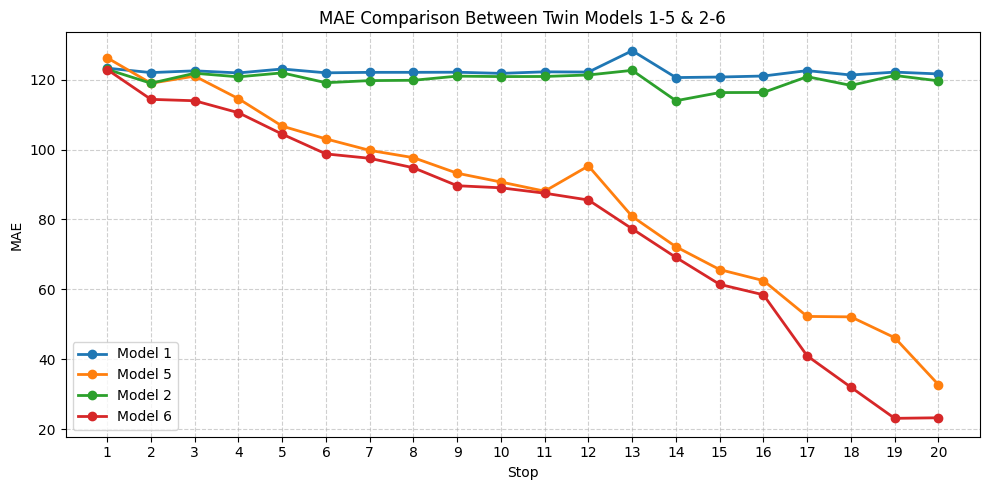

In [85]:
import matplotlib.pyplot as plt

# --- Extract MAE values ---
stops = list(range(1,21))
mae1 = evaluation_df_1['MAE'].to_list()[:20]
mae5 = evaluation_df_5['MAE'].to_list()[:20]
mae2 = [v['MAE'] for v in results2.values()]
mae6 = [v['MAE'] for v in results6.values()]

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(stops, mae1[:20], marker='o', label='Model 1', linewidth=2)
plt.plot(stops, mae5[:20], marker='o', label='Model 5', linewidth=2)
plt.plot(stops, mae2[:20], marker='o', label='Model 2', linewidth=2)
plt.plot(stops, mae6[:20], marker='o', label='Model 6', linewidth=2)
plt.xticks(stops)
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between Twin Models 1-5 & 2-6')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Comparison and % difference between model 2 and 6

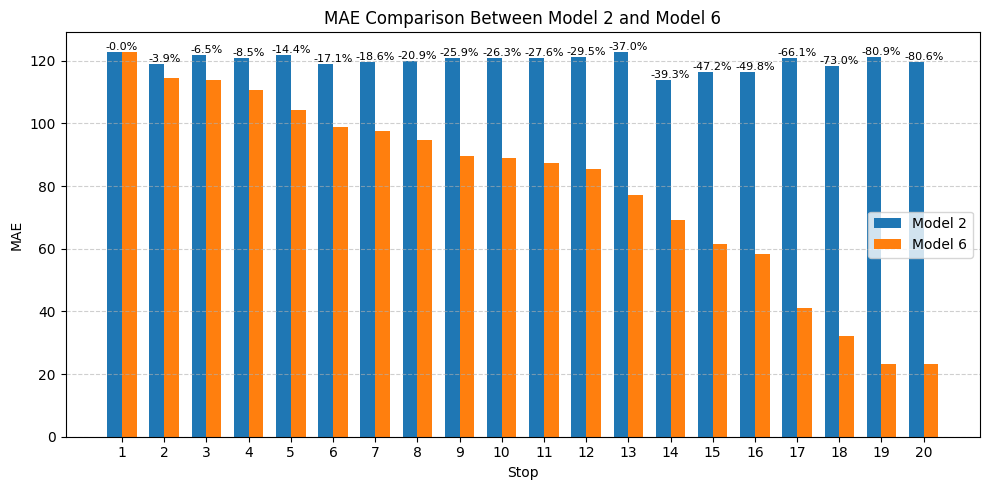

In [55]:
import matplotlib.pyplot as plt
import numpy as np

stops = np.arange(1, 21)
mae2 = np.array([v['MAE'] for v in results2.values()])
mae6 = np.array([v['MAE'] for v in results6.values()])

# Compute % change: (new - old) / old * 100
pct_change = ((mae6 - mae2) / mae2) * 100

# Plot setup
x = np.arange(len(stops))
width = 0.35

plt.figure(figsize=(10,5))
bars1 = plt.bar(x - width/2, mae2, width, label='Model 2')
bars2 = plt.bar(x + width/2, mae6, width, label='Model 6')

# Annotate % difference
for i in range(len(stops)):
    plt.text(x[i], max(mae2[i], mae6[i]) + 0.01, f"{pct_change[i]:.1f}%",
             ha='center', va='bottom', fontsize=8, rotation=0)

plt.xticks(x, stops)
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between Model 2 and Model 6')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


###**MODEL 7 XGBoost on single stops**
This model is based on model 3 but with all the features from the advanced ITS

In [110]:
# dropping irrelevant features
dfB_model7=dfB.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number', 'arrival_delay'], axis=1)

In [58]:
df7 = {}
models7 = {}
results7 = {}

# Define the grid of hyperparameters

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


for i in range(1, 21):
    # Filter data for this stop
    dfB_model7_i = dfB_model7[dfB_model7['stop_sequence'] == i].copy()
    df7[f'stop_{i}'] = dfB_model7_i

    # Split by date
    dfB_model7_train = dfB_model7_i[dfB_model7_i['Calendar_date'] < 20220600].copy()
    dfB_model7_test = dfB_model7_i[dfB_model7_i['Calendar_date'] >= 20220600].copy()

    # Drop non-predictive columns
    cols_to_drop = ['Calendar_date', 'stop_sequence']
    X_train = dfB_model7_train.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_train = dfB_model7_train['arrival_delay_stop_20']

    X_test = dfB_model7_test.drop(cols_to_drop + ['arrival_delay_stop_20'], axis=1)
    y_test = dfB_model7_test['arrival_delay_stop_20']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create XGBRegressor
    xgb = XGBRegressor(random_state=42)

    # Grid search
    random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,       # number of random combinations to try
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42
    )
    random_search.fit(X_train_scaled, y_train)

    # Best model
    best_model = random_search.best_estimator_
    models7[f'model_stop_{i}'] = best_model

    # Evaluate
    y_pred = best_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    results7[f'stop_{i}'] = {
        'R2': r2,
        'MAE': mae,
        'MSE': mse,
        'BestParams': random_search.best_params_
    }

# Display summary
pd.DataFrame(results7).T


,R2,MAE,MSE,BestParams
stop_1,0.52476,121.107704,25215.136719,"{'subsample': 0.7, 'n_estimators': 100, 'max_d..."
stop_2,0.60396,111.173286,21012.972656,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_3,0.620639,109.506317,20128.009766,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_4,0.633796,107.724632,19429.925781,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_5,0.673433,101.549698,17326.923828,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_6,0.701519,96.320404,15836.71582,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_7,0.713305,94.968674,15211.393555,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_8,0.733735,90.995064,14127.413086,"{'subsample': 0.7, 'n_estimators': 200, 'max_d..."
stop_9,0.75264,87.492859,13124.378906,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."
stop_10,0.75877,86.446213,12799.136719,"{'subsample': 0.8, 'n_estimators': 400, 'max_d..."


### **MODEL 8 - Clustering**
I plan to modify the data provided to have timeseries that show the delay fluctuation at different stops, after which I will use the data provided and try to estimate the delay from the two delays that we have: `origin_delay` and `upstream_stop_delay`



In [59]:
dfB_model8=dfB.copy()

In [61]:
# Separating the df to not leak any data
dfB_model8_train=dfB_model8[dfB_model8['Calendar_date']<20220600]
dfB_model8_test=dfB_model8[dfB_model8['Calendar_date']>=20220600].copy()

vectorizing the delays to turn them into time-series

In [62]:
# Define number of stops
n_stops = 27
# Find number of total trips
n_rows = len(dfB_model8_train)
n_trips = int(n_rows / n_stops)

# Extracting the delays
arrival_delays = dfB_model8_train['arrival_delay'].values

# --- Option 1: each row = one trip, each column = one stop ---
vectorized_delays = arrival_delays.reshape(n_trips, n_stops)

# --- Option 2: transpose if you prefer stops as rows ---
# vectorized_delays = delays.reshape(n_trips, n_stops).T

print(vectorized_delays.shape)


(17461, 27)


Normalization and first test of k-means clustering

[3707  947 5327 2168 4996  316]


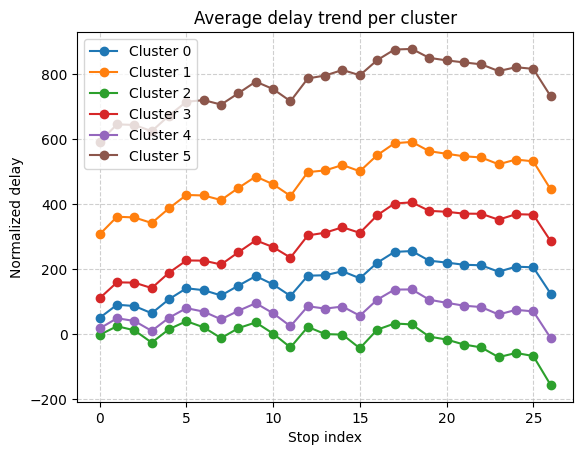

In [112]:
# normalize each trip (row-wise)
scaler = StandardScaler()
vectorized_delays_scaled = scaler.fit_transform(vectorized_delays)

from sklearn.cluster import KMeans

# clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(vectorized_delays)

# plotting centroids
print(np.bincount(labels))
n_clusters = len(np.unique(labels))
for c in range(n_clusters):
    cluster_mean = np.nanmean(vectorized_delays[labels == c], axis=0)
    plt.plot(cluster_mean, label=f'Cluster {c}', marker='o')
plt.xlabel('Stop index')
plt.ylabel('Normalized delay')
plt.title('Average delay trend per cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This part of the code is quite complex, a brief description is provided in the report

In [66]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances


# 1. Cluster the training trips
n_clusters = [2,10,25]

clustering_results={}
for n_clusterss in n_clusters:
  kmeans = KMeans(n_clusters=n_clusterss, random_state=42, n_init=10)
  labels_train = kmeans.fit_predict(vectorized_delays)

  # 2. Compute centroids (absolute delays)
  centroids = []
  n_stops = vectorized_delays.shape[1]

  for c in range(n_clusterss):
      cluster_trips = vectorized_delays[labels_train == c]
      centroid = np.nanmean(cluster_trips, axis=0)  # shape (n_stops,)
      centroids.append(centroid.reshape(1, -1))     # shape (1, n_stops)

  # 3. Predict next stop for each row in dfB_model7_test

  stop_mae = []
  stop_mape = []

  # unique stops in the dataset, limited to stop 20
  stops = sorted(dfB_model8_test['stop_sequence'].unique())[:20]
  n_stops = vectorized_delays.shape[1]  # for centroid indexing

  for stop in stops:
      # rows for this stop
      df_stop = dfB_model8_test[dfB_model8_test['stop_sequence'] == stop].copy()

      closest_centroid_indices = []
      predicted_20 = []

      for idx, row in df_stop.iterrows():
          stop_idx = int(row['stop_sequence']) - 1

          # Skip if next stop is out of bounds
          if stop_idx >= n_stops - 1:
              closest_centroid_indices.append(np.nan)
              predicted_20.append(np.nan)
              continue

          # Observed vector
          observed = np.array([
              row['upstream_stop_delay'],
              row['origin_delay']
          ]).reshape(1, -1)

          # Compare to centroids
          distances = []
          for centroid in centroids:
              centroid_vector = np.array([
                  centroid[0, stop_idx - 1],
                  centroid[0, 0]
              ]).reshape(1, -1)

              d = pairwise_distances(observed, centroid_vector, metric='euclidean')[0, 0]
              distances.append(d)

          # Closest centroid
          closest = np.argmin(distances)
          closest_centroid_indices.append(closest)

          # Predict stop 20
          predicted_delay = centroids[closest][0, 19]
          predicted_20.append(predicted_delay)

      # Add predictions to DataFrame
      df_stop['closest_centroid'] = closest_centroid_indices
      df_stop['predicted_20'] = predicted_20

      # Evaluate
      mask = ~df_stop['predicted_20'].isna()
      mae = np.mean(np.abs(df_stop.loc[mask, 'predicted_20'] - df_stop.loc[mask, 'arrival_delay_stop_20']))
      mape = np.mean(np.abs((df_stop.loc[mask, 'predicted_20'] - df_stop.loc[mask, 'arrival_delay_stop_20']) / df_stop.loc[mask, 'arrival_delay_stop_20']))

      stop_mae.append(mae)
      stop_mape.append(mape)

  # Convert to DataFrame for easy plotting/comparison
  df_performance = pd.DataFrame({
      'stop_sequence': stops,
      'MAE': stop_mae,
      'MAPE': stop_mape
  })
  clustering_results[f'k_{n_clusterss}']=df_performance
  print(df_performance)

    stop_sequence         MAE  MAPE
0               1  140.811529   inf
1               2  142.001057   inf
2               3  139.704792   inf
3               4  139.290927   inf
4               5  137.430865   inf
5               6  133.850348   inf
6               7  132.138718   inf
7               8  131.835806   inf
8               9  129.717478   inf
9              10  126.548047   inf
10             11  124.794451   inf
11             12  123.424788   inf
12             13  122.112485   inf
13             14  120.401524   inf
14             15  117.719349   inf
15             16  115.321804   inf
16             17  113.269158   inf
17             18  110.390124   inf
18             19  108.667386   inf
19             20  108.303579   inf
    stop_sequence         MAE  MAPE
0               1  128.652929   inf
1               2  155.272573   inf
2               3  149.851410   inf
3               4  149.592300   inf
4               5  145.809978   inf
5               6  135.75486

Plot of the MAE obtained from the clustering models

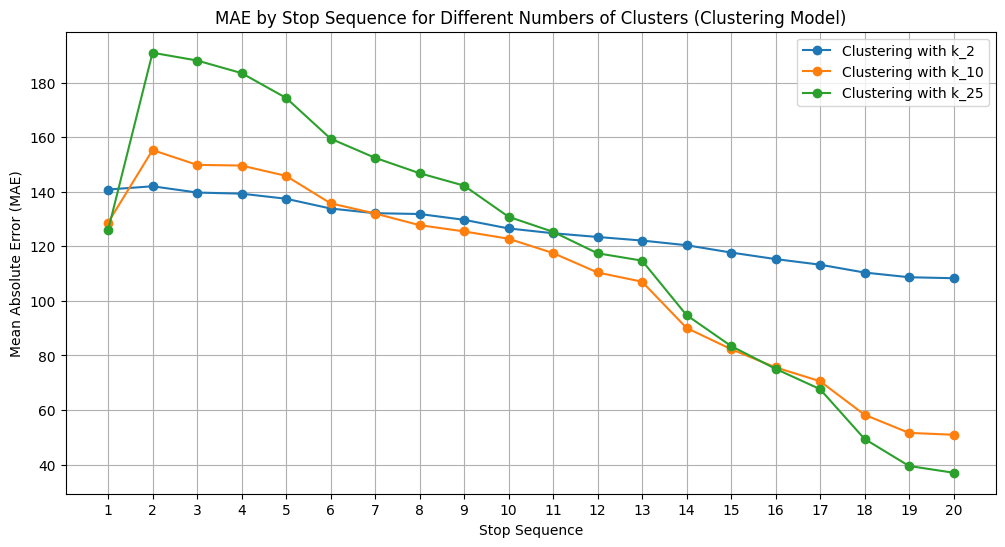

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))

# Iterate through the clustering results dictionary and plot the MAE for each key (number of clusters)
for key, df_results in clustering_results.items():
    plt.plot(df_results['stop_sequence'], df_results['MAE'], marker='o', linestyle='-', label=f'Clustering with {key}')

plt.title('MAE by Stop Sequence for Different Numbers of Clusters (Clustering Model)')
plt.xlabel('Stop Sequence')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(df_performance['stop_sequence']) # Use stop sequences as x-ticks
plt.legend()
plt.grid(True)
plt.show()

### **MODEL 9 - NN**

In [68]:
dfB_model9=dfB.copy()

A simple set-up of the NN with a loop to train multiple NN on different stops

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

results9 = {}

for i in range(1, 20, 2):
    print(f"\n=== Training model for stop_{i} ===")

    # Data selection
    X_train_scaled = test_train6[f'stop_{i}']['X_train_scaled']
    X_test_scaled  = test_train6[f'stop_{i}']['X_test_scaled']
    y_train = test_train6[f'stop_{i}']['y_train']
    y_test  = test_train6[f'stop_{i}']['y_test']

    # Define model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compile
    model.compile(optimizer=Adam(1e-4), loss='mae', metrics=['mae'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

    # Fit model
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop, reduce_lr]
    )

    # Predictions
    y_pred = model.predict(X_test_scaled).flatten()

    # Metrics
    r2  = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    results9[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE': mse}

    print(f"stop_{i}: R2={r2:.3f}, MAE={mae:.3f}, MSE={mse:.3f}")

# Done
print("\nAll results computed")



=== Training model for stop_1 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_1: R2=0.495, MAE=123.053, MSE=26771.336

=== Training model for stop_3 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_3: R2=0.589, MAE=113.363, MSE=21832.051

=== Training model for stop_5 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_5: R2=0.663, MAE=102.768, MSE=17899.916

=== Training model for stop_7 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
stop_7: R2=0.703, MAE=96.220, MSE=15731.884

=== Training model for stop_9 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
stop_9: R2=0.750, MAE=88.029, MSE=13281.295

=== Training model for stop_11 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_11: R2=0.766, MAE=85.063, MSE=12416.518

=== Training model for stop_13 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_13: R2=0.805, MAE=77.845, MSE=10368.811

=== Training model for stop_15 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_15: R2=0.867, MAE=62.072, MSE=7053.115

=== Training model for stop_17 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_17: R2=0.945, MAE=41.336, MSE=2937.354

=== Training model for stop_19 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
stop_19: R2=0.981, MAE=24.657, MSE=1005.778

All results computed ✅


### **CONCLUSION**

The following plot will show the error of every model's predictions from every stop before stop 20

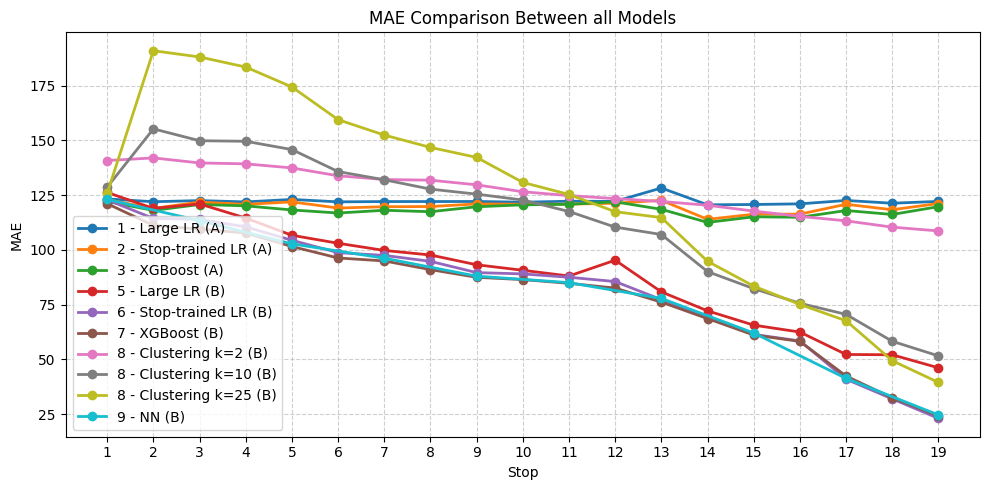

In [71]:
import matplotlib.pyplot as plt

# --- Extract MAE values ---
stops = list(range(1,20))
mae1=evaluation_df_1['MAE'].to_list()
mae3 = [v['MAE'] for v in results3.values()]
mae2 = [v['MAE'] for v in results2.values()]
mae5=evaluation_df_5['MAE'].to_list()
mae6 = [v['MAE'] for v in results6.values()]
mae7 = [v['MAE'] for v in results7.values()]
mae8_2 = clustering_results['k_2']['MAE']
mae8_10 = clustering_results['k_10']['MAE']
mae8_25 = clustering_results['k_25']['MAE']
# Existing odd-numbered stops
stops9 = sorted(int(k.split('_')[1]) for k in results9.keys())
mae9_values = [results9[f'stop_{i}']['MAE'] for i in stops9]
# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(stops, mae1[:19], marker='o', label='1 - Large LR (A)', linewidth=2)
plt.plot(stops[:19], mae2[:19], marker='o', label='2 - Stop-trained LR (A)', linewidth=2)
plt.plot(stops[:19], mae3[:19], marker='o', label='3 - XGBoost (A)', linewidth=2)
plt.plot(stops, mae5[:19], marker='o', label='5 - Large LR (B)', linewidth=2)
plt.plot(stops[:19], mae6[:19], marker='o', label='6 - Stop-trained LR (B)', linewidth=2)
plt.plot(stops[:19], mae7[:19], marker='o', label='7 - XGBoost (B)', linewidth=2)
plt.plot(stops[:19], mae8_2[:19], marker='o', label='8 - Clustering k=2 (B)', linewidth=2)
plt.plot(stops[:19], mae8_10[:19], marker='o', label='8 - Clustering k=10 (B)', linewidth=2)
plt.plot(stops[:19], mae8_25[:19], marker='o', label='8 - Clustering k=25 (B)', linewidth=2)
plt.plot(stops9, mae9_values, marker='o', label='9 - NN (B)', linewidth=2)
plt.xticks(stops)
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between all Models')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
